In [1]:
#IMPORTING SETUP PACKAGES
import statsmodels.formula.api as smf
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

pd.set_option('display.max_rows', 500)

In [2]:
df = pd.read_pickle('/Users/gabriele.sabato/PycharmProjects/raw_data/DataFrames/Top1000_seller_YTD_group_by_item_visit.pickle')


In [23]:
print(df.item_code.nunique())



926


In [4]:
print(df.dtypes)

min_date                  object
max_date                  object
item_code                 object
item_price               float64
delivery_weeks             int64
avg_sales                float64
avg_unique_views         float64
conv_rate                float64
bin                        int32
item_parent_item_code     object
item_main_category        object
item_sub_category_1       object
item_sub_category_2       object
log_price                float64
log_delivery_weeks       float64
log_sales                float64
log_avg_unique_views     float64
log_conv_rate            float64
dtype: object


In [5]:
def filter_df(DF = df,bins=6, avg_PDP = 19.):
    df_filt = DF[DF['bin'] > bins]
    df_items = df_filt.groupby('item_code').item_price.nunique() > 1
    df_filt  = df_filt.merge(df_items,on='item_code',how='inner')
    df_filt  = df_filt[df_filt['item_price_y']== True]
    #filter PDP
    #print(df_filt)
    df_filt = df_filt[df_filt['avg_unique_views'] > avg_PDP]
    #print(df_filt)
    return df_filt

In [22]:
df_filt = filter_df(df)


print(df_filt.item_code.nunique())

813


In [7]:
#introducing the similarity score 
sim_score = pd.read_parquet('/Users/gabriele.sabato/PycharmProjects/raw_data/recommendations_prod/part-00000-5f77392a-0bfa-4f0b-a4ae-d816ce2d71de-c000.snappy.parquet')

In [8]:
sim_score

,sku,recommended_sku,score
0,000000001000200072,000000001000200087,0.260000
1,000000001000200072,000000001000183538,0.216580
2,000000001000200072,000000001000142209,0.200000
3,000000001000200072,000000001000204906,0.190794
4,000000001000200072,000000001000183468,0.183980
...,...,...,...
3827600,000000001000064787,000000001000115010,0.203238
3827601,000000001000064787,000000001000112641,0.201339
3827602,000000001000064787,000000001000046204,0.200052
3827603,000000001000064787,000000001000114086,0.199867


In [9]:
# Filter table with only topX item_code

unique_item_codes = list(df_filt.item_code.unique())


sim_score_filt = sim_score[sim_score['sku'].isin(unique_item_codes)]

sim_score_filt

,sku,recommended_sku,score
2440,000000001000113295,000000001000008545,0.900430
2441,000000001000113295,000000001000179342,0.761525
2442,000000001000113295,000000001000229604,0.690047
2443,000000001000113295,000000001000211591,0.677586
2444,000000001000113295,000000001000220428,0.604604
...,...,...,...
3818835,000000001000114877,000000001000174096,0.227683
3818836,000000001000114877,000000001000007393,0.226087
3818837,000000001000114877,000000001000201087,0.222124
3818838,000000001000114877,000000001000150640,0.208160


In [10]:
#Create a map with X subset for X linear fit:

def create_map(list_of_items = unique_item_codes , df=sim_score_filt, score_cut = 0.):
    map_of_items = {}
    for item_code in list_of_items:
        df_mod = df[df['sku'] == item_code]
        df_score_filt = df_mod[df_mod['score'] > score_cut]
        final_set_sku = list(df_score_filt.recommended_sku)
        final_set_sku.insert(0,item_code)
        map_of_items[item_code] = final_set_sku
    #print(map_of_items)
    return map_of_items


In [11]:
sim_score_bin = [0.16]#0.3,0.4,0.5,0.6,0.7,0.8,0.9]




In [12]:
map_of_map_of_items = {}
for sim_score_i in sim_score_bin:
    Map_of_Items = create_map(score_cut = sim_score_i)
    map_of_map_of_items[str(sim_score_i)] = Map_of_Items
print(map_of_map_of_items)

{'0.16': {'000000001000021922': ['000000001000021922', '000000001000209426', '000000001000166799', '000000001000160236', '000000001000021908', '000000001000180824', '000000001000129691', '000000001000071650', '000000001000193633', '000000001000021916', '000000001000047786', '000000001000022019', '000000001000208980', '000000001000158785', '000000001000227892', '000000001000087660', '000000001000174166', '000000001000173883', '000000001000224889', '000000001000167468', '000000001000087616'], '000000001000005727': ['000000001000005727', '000000001000054049', '000000001000005734', '000000001000015678', '000000001000006086', '000000001000183903', '000000001000167292', '000000001000015958', '000000001000189803', '000000001000163191', '000000001000170692', '000000001000097658', '000000001000112668', '000000001000128953', '000000001000123390', '000000001000163168', '000000001000229587', '000000001000178559', '000000001000209145', '000000001000007435', '000000001000016087'], '00000000100000782

In [13]:
#load greater dataset 
largest_dataset = '/Users/gabriele.sabato/PycharmProjects/raw_data/DataFrames/All_catalogue_seller_YTD_group_by_item_visit.pickle'
dataset10k = '/Users/gabriele.sabato/PycharmProjects/raw_data/DataFrames/Top10000_seller_YTD_group_by_item_visit.pickle'

#df_k = pd.read_pickle(dataset10k)
df_k = pd.read_pickle(largest_dataset)

In [24]:
PDP_bin = [19]#,30,40,50]

In [25]:
df_PDP_bin_filt = {}
for PDP_view in PDP_bin:
    df_k_filt = filter_df(df_k, avg_PDP= PDP_view)
    df_PDP_bin_filt[PDP_view] = df_k_filt
    #print(df_k_filt)

#print(df_PDP_bin_filt)


In [29]:
def create_map_of_dataframes(items_map = Map_of_Items,df=df_filt):
    map_of_df = {}
    for key in items_map.keys():
        items  = items_map[key]
        #print(f'Item_code = {key}')
        
        df_mod = df[df['item_code'].isin(items)]
        #
        #print(f'Number of items per cluster {df_mod.item_code.nunique()}')
        map_of_df[key]= df_mod
    return map_of_df



In [30]:
def run_model(item_code, df, map_results):
    #print('\n')
    #print(f'Running model for the item = {item_code}')
    wls_cr_with_fe = smf.wls("conv_rate ~ log_price + log_delivery_weeks + C(item_code)", df, weights=df['bin']).fit()
    #print(wls_cr_with_fe.summary())
    beta_log_price, beta_std_err_log_price = wls_cr_with_fe.params[-2].round(4),wls_cr_with_fe.bse[-2].round(4)
    beta_log_del, beta_std_err_log_del = wls_cr_with_fe.params[-1].round(4),wls_cr_with_fe.bse[-1].round(4)
    Result_log_price = 'Log_price  = ' + str(beta_log_price) + ' ± ' + str(beta_std_err_log_price)
    Result_log_del = 'Log_del_week = ' + str(beta_log_del) + ' ± ' + str(beta_std_err_log_del)
    flag_stat_ok = abs((3*beta_std_err_log_price)/beta_log_price) < 1.

    if flag_stat_ok:
        #print(f'Enough statistics for the item = {item_code}')
        #print(Result_log_price)
        #print(Result_log_del)
        map_results[item_code] = [beta_log_price, beta_std_err_log_price, beta_log_del,beta_std_err_log_del, df.item_code.nunique(), True]
        #print(map_results[item_code])
        return True
    else:
        #print(f'Not enough statistics for the item = {item_code}')
        #print(Result_log_price)
        #print(Result_log_del)
        map_results[item_code] = [beta_log_price, beta_std_err_log_price, beta_log_del,beta_std_err_log_del, df.item_code.nunique(), False]
        #print(map_results[item_code])
        return False


In [31]:
df_result = pd.DataFrame()

map_of_maps_of_df = {}
#print('Cut on PDP, sim_score, result = ')
for PDP_cut in df_PDP_bin_filt.keys():
    for score_cut in  map_of_map_of_items.keys():
        map_of_dfs = create_map_of_dataframes(map_of_map_of_items[score_cut],df=df_PDP_bin_filt[PDP_cut])
        map_of_maps_of_df[PDP_cut] = map_of_dfs
        print(f'Number of items passing the PE cut {len(map_of_dfs)}')

        map_result = {}

        #print("Model used: conv_rate ~ log_price + log_delivery_weeks + C(item_code)\n")
        map_items_stat = {}
        for key in map_of_dfs.keys():
            map_items_stat[key] = run_model(key, map_of_dfs[key], map_result)

            #print(map_result)

        items_stat_series = pd.Series(map_items_stat)
        #print(map_items_stat)
        #print(items_stat_series)


        
        x,y, y_err, rel_err = {'True':[],'False':[]},{'True':[],'False':[]},{'True':[],'False':[]},{'True':[],'False':[]}
        for i_code,flag in items_stat_series.items():
        #flag=T
            if flag == True:

                y['True'].append(map_result[i_code][0])
                y_err['True'].append(map_result[i_code][1])
                x['True'].append(map_result[i_code][-1])
                rel_err['True'].append(abs(map_result[i_code][1]/map_result[i_code][0]))
            else:
                y['False'].append(map_result[i_code][0])
                y_err['False'].append(map_result[i_code][1])
                x['False'].append(map_result[i_code][-1])
                rel_err['False'].append(abs(map_result[i_code][1]/map_result[i_code][0]))
                continue
        #print(f'{PDP_cut},{score_cut} , {len(x)}')
        df_result = pd.DataFrame.from_dict(map_result, orient='index', columns = ['PE', 'PE_err', 'log_del_week', 'log_del_week_err', 'Cluster_size', 'has_enough_stat'])
        print (df_result.head(100))


Number of items passing the PE cut 813
                        PE  PE_err  log_del_week  log_del_week_err  \
000000001000021922 -0.0188  0.0034       -0.0041            0.0009   
000000001000005727 -0.0460  0.0073        0.0003            0.0007   
000000001000007822 -0.0246  0.0073        0.0005            0.0005   
000000001000124600 -0.0234  0.0053       -0.0003            0.0003   
000000001000008827 -0.0260  0.0039       -0.0006            0.0003   
000000001000054998 -0.0142  0.0053       -0.0018            0.0008   
000000001000091265 -0.0553  0.0092       -0.0029            0.0028   
000000001000012742 -0.0350  0.0142        0.0009            0.0006   
000000001000073238 -0.0163  0.0097       -0.0036            0.0014   
000000001000076760 -0.0095  0.0057       -0.0016            0.0006   
000000001000191237 -0.0128  0.0034        0.0005            0.0002   
000000001000061845 -0.0254  0.0060       -0.0037            0.0008   
000000001000054183 -0.0123  0.0025       -0.0026   

In [40]:
df_result_true = df_result[df_result['has_enough_stat']==True]
print(len(df_result_true.index))
#print(df_result.head(100))

df_filt_result_high = df_result_true[df_result_true['PE'] < -0.05]

#print(df_filt_result_high.head(100))

items_to_test = list(df_filt_result_high.index.values)
print(items_to_test)
print(len(items_to_test))
#for item in items_to_test:
    #print(map_of_dfs[str(item)])
    #df_of_df = pd.DataFrame().from_dict(map_of_dfs[str(item)], orient = 'columns')
    #print(df_of_df)#
#    break

403
['000000001000091265', '000000001000007432', '000000001000024323', '000000001000024281', '000000001000024683', '000000001000112681', '000000001000007449', '000000001000118440', '000000001000064492', '000000001000175647', '000000001000092579', '000000001000123214', '000000001000024328', '000000001000091266', '000000001000007431', '000000001000024325', '000000001000008146', '000000001000022708', '000000001000016131', '000000001000112303', '000000001000015943', '000000001000175682', '000000001000007448', '000000001000080483', '000000001000091264', '000000001000022573', '000000001000091298', '000000001000024947', '000000001000008482', '000000001000024315', '000000001000022710', '000000001000022586', '000000001000022709', '000000001000025087', '000000001000157255', '000000001000022575', '000000001000178468', '000000001000022562', '000000001000091289', '000000001000123395', '000000001000022578', '000000001000016019', '000000001000015944', '000000001000024954', '000000001000110389', '0000

In [41]:
df_filt_result_low = df_result_true[df_result_true['PE'] > -0.02]
#print(df_filt_result_low.head(100))
items_to_test_low = list(df_filt_result_low.index.values)
print(items_to_test_low)
print(len(items_to_test_low))

['000000001000021922', '000000001000191237', '000000001000054183', '000000001000007079', '000000001000054980', '000000001000051675', '000000001000071068', '000000001000008748', '000000001000012484', '000000001000016048', '000000001000092353', '000000001000110022', '000000001000064533', '000000001000037682', '000000001000039125', '000000001000117189', '000000001000007105', '000000001000016061', '000000001000022035', '000000001000123519', '000000001000012645', '000000001000064654', '000000001000113344', '000000001000015607', '000000001000027397', '000000001000120238', '000000001000047976', '000000001000126041', '000000001000039171', '000000001000008752', '000000001000057600', '000000001000008121', '000000001000064511', '000000001000012802', '000000001000012776', '000000001000113300', '000000001000092125', '000000001000027390', '000000001000007405', '000000001000172943', '000000001000054995', '000000001000086499', '000000001000118957', '000000001000012828', '000000001000008000', '00000000

In [42]:
df_result_false = df_result[df_result['has_enough_stat']==False]
#print(df_result_false.head(100))
items_false = list(df_result_false.index.values)
print(items_false)
print(len(items_false))

['000000001000054998', '000000001000012742', '000000001000073238', '000000001000076760', '000000001000080376', '000000001000054984', '000000001000050884', '000000001000054946', '000000001000097071', '000000001000032245', '000000001000055018', '000000001000071064', '000000001000097073', '000000001000008769', '000000001000150713', '000000001000055017', '000000001000028761', '000000001000056198', '000000001000124223', '000000001000101016', '000000001000076722', '000000001000136054', '000000001000092015', '000000001000092019', '000000001000047981', '000000001000008808', '000000001000027404', '000000001000104069', '000000001000012837', '000000001000076827', '000000001000008183', '000000001000059226', '000000001000076724', '000000001000008813', '000000001000007052', '000000001000110200', '000000001000008053', '000000001000183881', '000000001000110720', '000000001000016128', '000000001000133193', '000000001000012790', '000000001000123851', '000000001000109912', '000000001000022053', '00000000

In [43]:
import matplotlib.lines as mlines

def create_legend(flag={'blue' : 'Items with sign stat', 'red': 'Items with not sign stat'}):
    good_stat_leg = []
    for key in flag.keys():
        good_stat_leg.append( mlines.Line2D([], [], color=key, marker = 'o',
                          markersize=6, label=flag[key]))
        
    plt.legend(handles=good_stat_leg)

<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


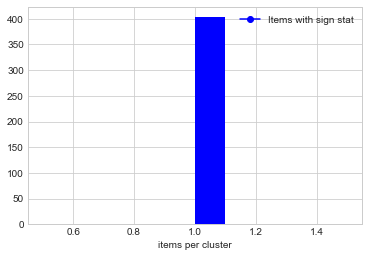

In [44]:
plt.hist(x['True'], color= 'blue')
plt.xlabel('items per cluster')
create_legend({'blue':'Items with sign stat'})
#plt.savefig('./plots/items_per_cluster_good.png')
plt.show()

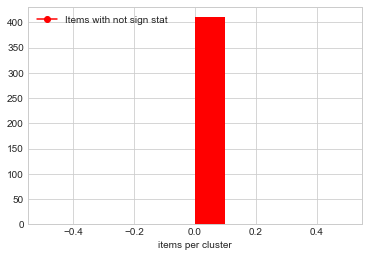

In [45]:
plt.hist(x['False'],color ='red')
plt.xlabel('items per cluster')
create_legend({'red':'Items with not sign stat'})
#plt.savefig('./plots/items_per_cluster_bad.png')
plt.show()

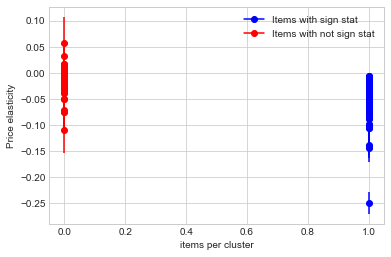

In [46]:
plt.errorbar(x['True'], y['True'], yerr=y_err['True'],fmt='o', c='blue')
plt.errorbar(x['False'], y['False'], yerr=y_err['False'],fmt='o',c='red')
plt.xlabel('items per cluster')
plt.ylabel('Price elasticity')


create_legend()
#plt.savefig('./plots/PE_vs_items_per_cluster.png')
plt.show()



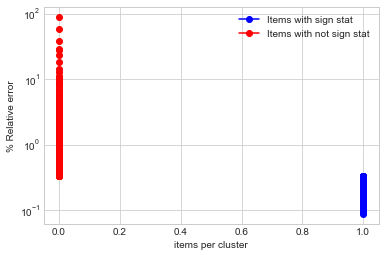

In [47]:
plt.scatter(x['False'],rel_err['False'],c='red')
plt.scatter(x['True'],rel_err['True'],c='blue')
plt.xlabel('items per cluster')
plt.ylabel('% Relative error')
plt.yscale('log')
create_legend()
#plt.savefig('./plots/Relative_error_vs_items_per_cluster.png')
plt.show()

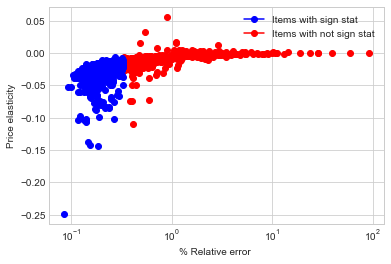

In [51]:
plt.scatter(rel_err['False'],y['False'],c='red')
plt.scatter(rel_err['True'],y['True'],c='blue')
plt.ylabel('Price elasticity')
plt.xlabel('% Relative error ')
plt.xscale('log')
#plt.yscale('log')
create_legend()
plt.savefig('./plots/Relative_error_vs_PE_top1k.png')
plt.show()



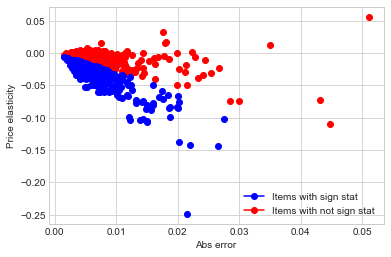

In [53]:
plt.scatter(y_err['False'],y['False'],c='red')
plt.scatter(y_err['True'],y['True'],c='blue')
plt.ylabel('Price elasticity')
plt.xlabel('Abs error ')
#plt.xscale('log')
create_legend()
plt.savefig('./plots/Abs_error_vs_PE_top1k.png')
plt.show()



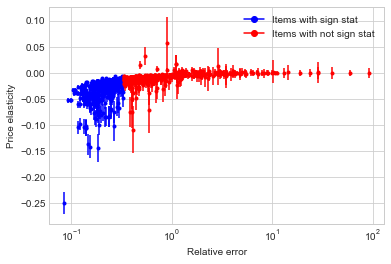

In [54]:
plt.errorbar(rel_err['True'], y['True'], yerr=y_err['True'],fmt='.', c='blue')
plt.errorbar(rel_err['False'], y['False'], yerr=y_err['False'],fmt='.',c='red')
plt.xlabel('Relative error')
plt.ylabel('Price elasticity')
plt.xscale('log')

create_legend()
plt.savefig('./plots/Rel_err_vs_PE_plus_abs_err_top1k.png')
plt.show()

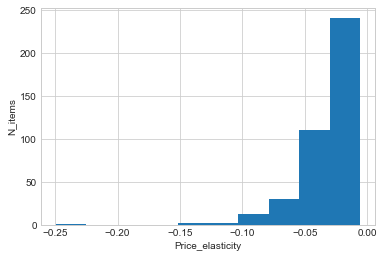

In [67]:
plt.hist(y['True'])
plt.xlabel('Price_elasticity')
plt.ylabel('N_items')
plt.show()


In [57]:
import statistics
print(statistics.median(y['True']))


-0.0257


In [88]:
def split(a, n):
    k, m = divmod(len(a), n)
    return (a[i * k + min(i, m):(i + 1) * k + min(i + 1, m)] for i in range(n))

y['True'].sort()
three_list = list(split(y['True'],3))


print(three_list[0][-1],three_list[1][-1] )

-0.0349 -0.0195 -0.0058


In [91]:
df_result_true_high = df_result_true[df_result_true['PE'] <= three_list[0][-1] ]
print(len(df_result_true_high.index))
df_result_true_medium = df_result_true[ (df_result_true['PE'] > three_list[0][-1] ) & ( df_result_true['PE'] <= three_list[1][-1])]
print(len(df_result_true_medium.index))
df_result_true_low = df_result_true[df_result_true['PE'] > three_list[1][-1] ]
print(len(df_result_true_low.index))

135
136
132


In [97]:
list_high   = list(df_result_true_high.index)
list_medium = list(df_result_true_medium.index)
list_low    = list(df_result_true_low.index)
#print(df_result_true_high.index)

In [98]:
df_result_true_high.to_csv('./pickle_files/Top1k_high_el.csv')
df_result_true_medium.to_csv('./pickle_files/Top1k_medium_el.csv')
df_result_true_low.to_csv('./pickle_files/Top1k_low_el.csv')

In [ ]:
import pickle
def save_obj(obj, name ):
    with open('pickle_files/'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)




In [40]:
save_obj(map_result,'top10_sim_score')
print(map_result)



{'000000001000054984': [-0.0113, 0.0061, -0.0001, 0.0002, 10, False], '000000001000073170': [-0.0201, 0.0051, -0.0006, 0.0004, 12, True], '000000001000054983': [-0.0114, 0.0071, -0.0001, 0.0002, 10, False], '000000001000015496': [-0.0032, 0.004, -0.0005, 0.0003, 7, False], '000000001000062031': [-0.0195, 0.0045, -0.0022, 0.0006, 18, True], '000000001000021539': [-0.011, 0.0041, -0.0002, 0.0004, 6, False], '000000001000113432': [0.0032, 0.0035, -0.0004, 0.0002, 13, False], '000000001000016133': [-0.0489, 0.0082, -0.0003, 0.0008, 19, True], '000000001000021540': [-0.0168, 0.0065, -0.0008, 0.0006, 6, False], '000000001000016021': [-0.0532, 0.0075, -0.0, 0.0009, 19, True]}


In [ ]:
wls_high_stat = smf.wls("log_conv_rate ~ log_price + log_delivery_weeks + C(item_code)", df_filt, weights=df_filt['bin']).fit()
print(wls_high_stat.summary())

In [22]:
wls_high_stat_del = smf.wls("log_conv_rate ~ log_price + delivery_weeks + C(item_code)", df_filt, weights=df_filt['bin']).fit()
print(wls_high_stat_del.summary())



                            WLS Regression Results                            
Dep. Variable:          log_conv_rate   R-squared:                       0.787
Model:                            WLS   Adj. R-squared:                  0.764
Method:                 Least Squares   F-statistic:                     33.53
Date:                Tue, 05 Jan 2021   Prob (F-statistic):          1.91e-191
Time:                        15:53:51   Log-Likelihood:                -758.67
No. Observations:                 795   AIC:                             1677.
Df Residuals:                     715   BIC:                             2052.
Df Model:                          79                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Inte

In [23]:
#wls_model_with_fe = smf.wls("log_sales ~ log_price + log_delivery_weeks + log_avg_unique_views + C(item_code)", df, weights=df['bin']).fit()
#print(wls_model_with_fe.summary())


In [24]:
#wls_model_with_fe_all_in = smf.wls("log_sales ~ log_price + log_delivery_weeks + log_avg_unique_views + log_conv_rate +  C(item_code)", df, weights=df['bin']).fit()
#print(wls_model_with_fe_all_in.summary())



In [25]:
#WLS CV rate vs the rest
wls_cr_with_fe = smf.wls("log_conv_rate ~ log_price + log_delivery_weeks + C(item_code)", df, weights=df['bin']).fit()
print(wls_cr_with_fe.summary())


                            WLS Regression Results                            
Dep. Variable:          log_conv_rate   R-squared:                       0.631
Model:                            WLS   Adj. R-squared:                  0.623
Method:                 Least Squares   F-statistic:                     82.56
Date:                Tue, 05 Jan 2021   Prob (F-statistic):               0.00
Time:                        15:53:51   Log-Likelihood:                -6828.7
No. Observations:                4592   AIC:                         1.385e+04
Df Residuals:                    4498   BIC:                         1.445e+04
Df Model:                          93                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Inte

In [26]:
def run_model(item_code, df):
    print(f'Running model for the item_code {item_code}')
    wls_cr_with_fe = smf.wls("conv_rate ~ log_price + log_delivery_weeks + C(item_code)", df, weights=df['bin']).fit()
    print(wls_cr_with_fe.summary())
    beta_log_price, beta_std_err_log_price = wls_cr_with_fe.params[-2].round(4),wls_cr_with_fe.bse[-2].round(4)
    beta_log_del, beta_std_err_log_del = wls_cr_with_fe.params[-1].round(4),wls_cr_with_fe.bse[-1].round(4)
    Result_log_price = 'Log_price  = ' + str(beta_log_price) + ' ± ' + str(beta_std_err_log_price)
    Result_log_del = 'Log_del_week = ' + str(beta_log_del) + ' ± ' + str(beta_std_err_log_del)



In [27]:
end_date = pd.to_datetime('2020-11-10').date()
df_before_BF = df[df['max_date'] <= end_date]
df_before_BF

,min_date,max_date,item_code,item_price,delivery_weeks,avg_sales,avg_unique_views,conv_rate,bin,item_parent_item_code,item_main_category,item_sub_category_1,item_sub_category_2,log_price,log_delivery_weeks,log_sales,log_avg_unique_views,log_conv_rate
0,2020-01-01,2020-01-07,000000001000054998,749.99,2,1.428571,72.857143,0.019608,7,000000008000006211,POLSTER,ECKSOFAS,LONGCHAIR,6.620060,0.693197,0.356745,4.288502,-3.926739
1,2020-01-01,2020-01-22,000000001000091265,599.99,1,1.818182,61.818182,0.029412,22,000000008000009860,MATRATZEN&LATTENROSTE,MATRATZEN,KALTSCHAUMMATRATZEN,6.396913,0.000100,0.597892,4.124199,-3.522966
2,2020-01-01,2020-01-02,000000001000021540,1449.99,2,1.500000,323.500000,0.004637,2,000000008000001826,POLSTER,WOHNLANDSCHAFTEN,WOHNLANDSCHAFTEN,7.279312,0.693197,0.405532,5.779199,-5.352397
3,2020-01-01,2020-01-07,000000001000054984,749.99,2,2.142857,152.142857,0.014085,7,000000008000006211,POLSTER,ECKSOFAS,LONGCHAIR,6.620060,0.693197,0.762187,5.024821,-4.255605
4,2020-01-01,2020-01-07,000000001000054946,1099.99,2,3.000000,275.000000,0.010909,7,000000008000006213,POLSTER,WOHNLANDSCHAFTEN,WOHNLANDSCHAFTEN,7.003056,0.693197,1.098646,5.616771,-4.509034
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4040,2020-11-10,2020-11-10,000000001000008546,249.99,2,13.000000,429.000000,0.030303,1,000000001000008546-P,BÜRO,SCHREIBTISCHE,GERADE SCHREIBTISCHE,5.521421,0.693197,2.564957,6.061457,-3.493213
4041,2020-11-10,2020-11-10,000000001000062032,1549.99,3,3.000000,240.000000,0.012500,1,000000008000006759,BETTEN,BOXSPRINGBETTEN,BOXSPRINGBETTEN,7.346004,1.098646,1.098646,5.480639,-4.374058
4043,2020-11-10,2020-11-10,000000001000062061,1649.99,7,2.000000,185.000000,0.010811,1,000000008000006759,BETTEN,BOXSPRINGBETTEN,BOXSPRINGBETTEN,7.408525,1.945924,0.693197,5.220356,-4.518001
4045,2020-11-10,2020-11-10,000000001000021703,749.99,5,8.000000,269.000000,0.029740,1,000000008000001862,POLSTER,ECKSOFAS,OTTOMANE,6.620060,1.609458,2.079454,5.594712,-3.511913


In [28]:
wls_cr_del_w_with_fe_before_BF = smf.wls("log_conv_rate ~ log_price + log_delivery_weeks + C(item_code)", df_before_BF, weights=df_before_BF['bin']).fit()
print(wls_cr_del_w_with_fe_before_BF.summary())


                            WLS Regression Results                            
Dep. Variable:          log_conv_rate   R-squared:                       0.641
Model:                            WLS   Adj. R-squared:                  0.632
Method:                 Least Squares   F-statistic:                     74.47
Date:                Tue, 05 Jan 2021   Prob (F-statistic):               0.00
Time:                        15:53:51   Log-Likelihood:                -5884.5
No. Observations:                3976   AIC:                         1.196e+04
Df Residuals:                    3882   BIC:                         1.255e+04
Df Model:                          93                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Inte

<AxesSubplot:xlabel='log_price'>

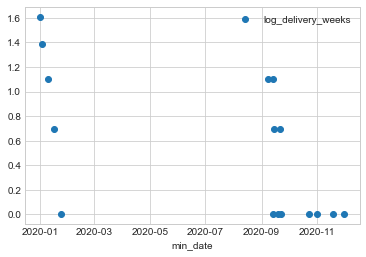

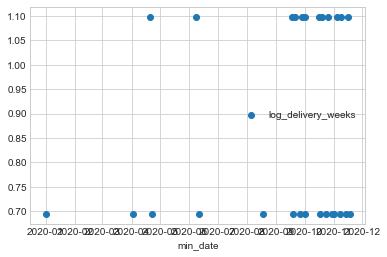

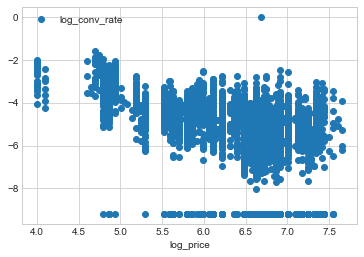

In [29]:
df[df['item_code']== '000000001000016019'].plot(x='min_date',y='log_delivery_weeks', style = 'o')
df[df['item_code']== '000000001000022573'].plot(x='min_date',y='log_delivery_weeks', style = 'o')
df_before_BF.plot(x='log_price',y='log_conv_rate', style = 'o')